In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COMP4471 Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/COMP4471 Project


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
import pathlib
import IPython.display as display
from PIL import Image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
AUTOTUNE = tf.data.experimental.AUTOTUNE

# from my_imageloader import read_folder_to_dataset

In [0]:
train_path = './images/manual/'
test_path = './images/test_img/'

data_dir = pathlib.Path(train_path) #default path
testdata_dir = pathlib.Path(test_path) #default path

In [0]:
image_count = len(list(data_dir.glob('*/*.jpg'))) #total num of images in the dataset

In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])

In [6]:
print('The dataset contains {} images for {} classes'.format(image_count, len(CLASS_NAMES)))

The dataset contains 1890 images for 35 classes


In [0]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2,
                                                                 horizontal_flip=True,
                                                                 validation_split=0.2
                                                                 )

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [54]:
train_data_gen = image_generator.flow_from_directory(
    str(data_dir),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    classes = list(CLASS_NAMES),
    subset='training') # set as training data

val_data_gen = image_generator.flow_from_directory(
    str(data_dir), # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    classes = list(CLASS_NAMES),
    subset='validation') # set as validation data

Found 1529 images belonging to 35 classes.
Found 363 images belonging to 35 classes.


In [97]:
test_data_gen = test_image_generator.flow_from_directory(directory=str(testdata_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                    class_mode = "sparse")

Found 85 images belonging to 35 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(5):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(testdata_dir/'*/*'))

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


In [0]:
train_ds = prepare_for_training(labeled_ds)
test_ds = prepare_for_training(test_labeled_ds)
image_batch, label_batch = next(iter(train_ds))

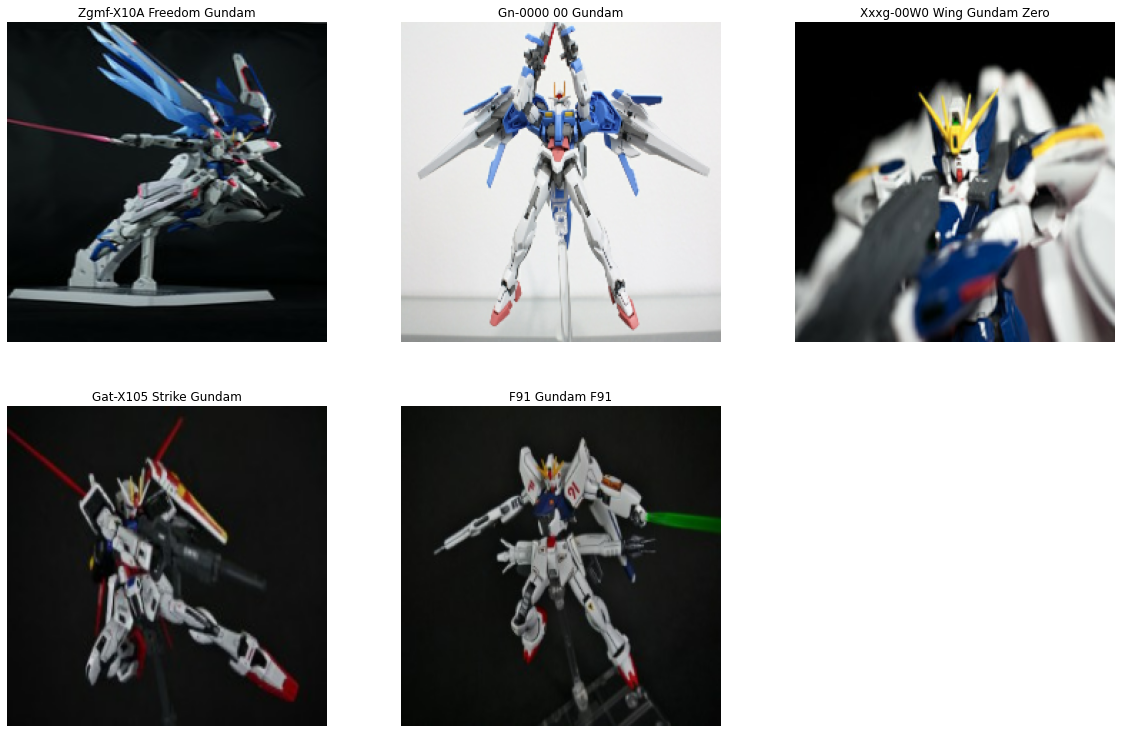

In [19]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
NCLASS = len(CLASS_NAMES)
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3
BATCH_SIZE = 32

In [55]:
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), include_top=False, weights='imagenet')
base_model.trainable = False

print(base_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [75]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(NCLASS, activation='sigmoid')(x)

model_3 = models.Model(inputs=base_model.input, outputs=x)

# model_3 = models.Sequential([
#                              base_model.layers[:3],
#                              layers.BatchNormalization(),
#                              base_model.layers[3:6],
#                              layers.BatchNormalization(),
#                              base_model.layers[6:11],
#                              layers.BatchNormalization(),
#                              base_model.layers[11:16],
#                              layers.BatchNormalization(),
#                              base_model.layers[16:],
#                              layers.GlobalAveragePooling2D(),
#                              layers.Dense(4096, activation='relu'),
#                              layers.Dropout(0.5),
#                              layers.Dense(4096, activation='relu'),
#                              layers.Dropout(0.5),
#                              layers.Dense(NCLASS, activation='sigmoid')
# ])

print(model_3.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
base_learning_rate = 0.0001
base_epochs = 30
model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [77]:
history = model_3.fit(train_data_gen, validation_data=val_data_gen, epochs=30, steps_per_epoch=40)

Epoch 1/30
40/40 [==============================] - 40s 991ms/step - loss: 3.5080 - accuracy: 0.0754 - val_loss: 3.4318 - val_accuracy: 0.0937
Epoch 2/30
40/40 [==============================] - 39s 977ms/step - loss: 3.2734 - accuracy: 0.0875 - val_loss: 3.2860 - val_accuracy: 0.0744
Epoch 3/30
40/40 [==============================] - 40s 1s/step - loss: 2.7286 - accuracy: 0.2490 - val_loss: 3.3185 - val_accuracy: 0.1928
Epoch 4/30
40/40 [==============================] - 40s 1s/step - loss: 2.1193 - accuracy: 0.4517 - val_loss: 3.2594 - val_accuracy: 0.1956
Epoch 5/30
40/40 [==============================] - 39s 964ms/step - loss: 1.7468 - accuracy: 0.5436 - val_loss: 3.1747 - val_accuracy: 0.2259
Epoch 6/30
40/40 [==============================] - 39s 981ms/step - loss: 1.5256 - accuracy: 0.6133 - val_loss: 3.1555 - val_accuracy: 0.2672
Epoch 7/30
40/40 [==============================] - 40s 988ms/step - loss: 1.3329 - accuracy: 0.6441 - val_loss: 3.0161 - val_accuracy: 0.3003
Epoch

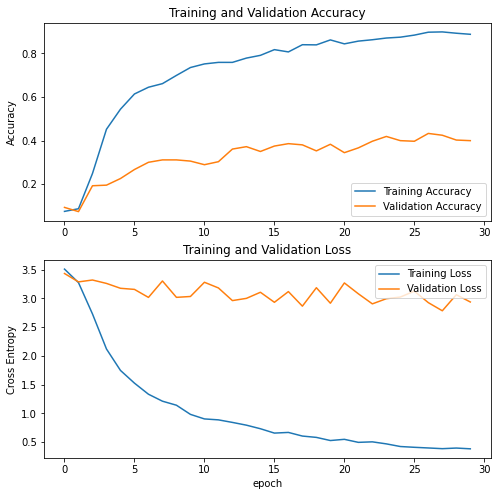

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [79]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [0]:
# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam'), 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [82]:
model_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [84]:
fine_tune_epochs = 20
total_epochs =  30 + fine_tune_epochs

history_fine = model_3.fit(train_data_gen,
                         validation_data=val_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=40,
                         initial_epoch =  history.epoch[-1])

Epoch 30/60
40/40 [==============================] - 40s 1000ms/step - loss: 0.0653 - accuracy: 0.9828 - val_loss: 3.0855 - val_accuracy: 0.4766
Epoch 31/60
40/40 [==============================] - 40s 1s/step - loss: 0.0600 - accuracy: 0.9796 - val_loss: 2.9258 - val_accuracy: 0.4821
Epoch 32/60
40/40 [==============================] - 39s 986ms/step - loss: 0.0611 - accuracy: 0.9804 - val_loss: 3.0867 - val_accuracy: 0.4793
Epoch 33/60
40/40 [==============================] - 40s 1s/step - loss: 0.0540 - accuracy: 0.9819 - val_loss: 2.8713 - val_accuracy: 0.4738
Epoch 34/60
40/40 [==============================] - 40s 1s/step - loss: 0.0563 - accuracy: 0.9835 - val_loss: 3.0686 - val_accuracy: 0.4270
Epoch 35/60
40/40 [==============================] - 40s 1s/step - loss: 0.0433 - accuracy: 0.9859 - val_loss: 2.8829 - val_accuracy: 0.4931
Epoch 36/60
40/40 [==============================] - 40s 1s/step - loss: 0.0503 - accuracy: 0.9804 - val_loss: 2.9482 - val_accuracy: 0.4848
Epoch 

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [0]:
# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam'), 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [88]:
model_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [89]:
fine_tune_epochs = 20
total_epochs =  total_epochs + fine_tune_epochs

history_fine = model_3.fit(train_data_gen,
                         validation_data=val_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=40,
                         initial_epoch = history_fine.epoch[-1])

Epoch 60/80
40/40 [==============================] - 41s 1s/step - loss: 0.0223 - accuracy: 0.9874 - val_loss: 2.9107 - val_accuracy: 0.5069
Epoch 61/80
40/40 [==============================] - 40s 1s/step - loss: 0.0203 - accuracy: 0.9898 - val_loss: 2.9909 - val_accuracy: 0.4959
Epoch 62/80
40/40 [==============================] - 41s 1s/step - loss: 0.0200 - accuracy: 0.9883 - val_loss: 3.2180 - val_accuracy: 0.4683
Epoch 63/80
40/40 [==============================] - 39s 981ms/step - loss: 0.0218 - accuracy: 0.9921 - val_loss: 2.9692 - val_accuracy: 0.5014
Epoch 64/80
40/40 [==============================] - 40s 999ms/step - loss: 0.0207 - accuracy: 0.9890 - val_loss: 2.9310 - val_accuracy: 0.4959
Epoch 65/80
40/40 [==============================] - 41s 1s/step - loss: 0.0189 - accuracy: 0.9874 - val_loss: 2.9563 - val_accuracy: 0.5041
Epoch 66/80
40/40 [==============================] - 41s 1s/step - loss: 0.0199 - accuracy: 0.9890 - val_loss: 2.8114 - val_accuracy: 0.5179
Epoch 6

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

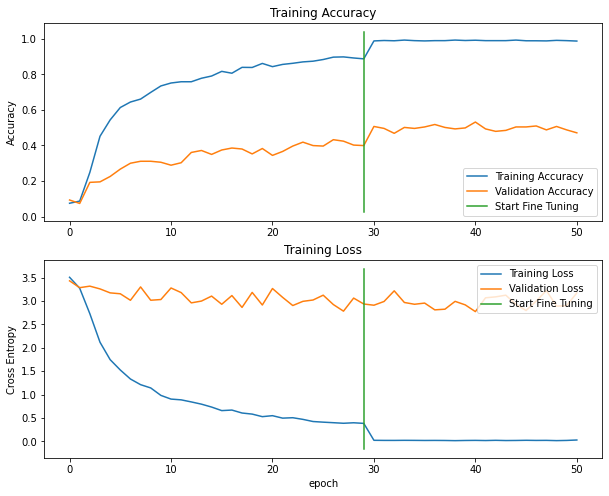

In [94]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.plot([29,29], plt.ylim(), label='Start Fine Tuning')
# plt.plot([59,59], plt.ylim(), label='Start Second Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.plot([29,29], plt.ylim(), label='Start Fine Tuning')
# plt.plot([59,59], plt.ylim(), label='Start Second Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [98]:
validation_steps=5

loss0, accuracy0 = model_3.evaluate(test_data_gen, steps = validation_steps)

3/5 [=================>............] - 23s 8s/step - loss: 0.6472 - accuracy: 0.8824
